In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
# load data
r_data = pd.read_csv("../result/join_weather_flower/Chrysanthemum_C0K490_古坑.csv")
r_data = r_data.dropna()
lc_data = pd.read_csv("../lunar_celeb_date.csv", encoding="utf-8")
r_data = r_data.join(lc_data.set_index("date"), on="Date")
r_data = r_data.reset_index()
r_data = r_data.drop(columns="index")
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
# r_data

In [2]:
# modify data p1
from scipy import stats
data_t_n = ['Temperature', 'RH', 'StnPres', 'WS', 'WSGust','d_tmp']
data_to_dummy = ["rain_class", "week", "Monthdate"]
col_fix =  ['T.Max', 'T.Min', 'Precp','Temperature', 'RH', 'StnPres', 'WS', 'WSGust']
# rm "/"
for col in col_fix:
    old = r_data[col]
    new = []
    for i in range(len(old)):
        try:
            new.append(float(old[i]))
            tmp = float(old[i])
        except ValueError:
            new.append(tmp)
    r_data[col] = new

# x_raw = r_data[col_fix]

rain  = r_data['Precp']
# rain_class function
def rain_c(precp):
    rain_class=[0,20]
    rain_tag = ["no_rain", "little_rain", "rain"]
    result = 0
    for d in rain_class:
        if precp>d:
            result = result + 1
    return rain_tag[result]

rain_class=[]
for precp in rain:
    rain_class.append(rain_c(precp))
# df_r["rain_class"]=rain_class
# print("0,<5,>5",np.bincount(rain_class))
d_tmp = r_data['T.Max'] - r_data['T.Min']

d = np.array(r_data["Date"])
day_new=[]
for date in d:
    result =  "date_" + date.split("-")[-1]
    day_new.append(result)

drop_c =['Date','T.Max', 'T.Min', 'Precp','avg_price', 'total_count','year',"month","flower"]
y_raw = r_data["avg_price"]
r_data = r_data.drop(columns=drop_c)
r_data["Monthdate"]= day_new
r_data["rain_class"]= rain_class
r_data["d_tmp"]= d_tmp
c =r_data.columns.to_list()

# to normalize

def to_zscore(df, col_x):
#     df_tmp = df
#     col = "Temperature"
    for col in col_x:
        df[col] = stats.zscore(df[col])
        df[col] = np.round(df[col], decimals=4)
# modify x p2

for col in data_to_dummy:
    dummy =pd.get_dummies(r_data[col])
    r_data = pd.concat([r_data, dummy], axis=1)
    r_data = r_data.drop([col], axis = 1)

to_zscore(r_data, data_t_n)
# modify y
y_pct  = np.array(y_raw.pct_change()[1:])

def y_to_class(v):
    t = 0
    y_class_range = [-0.1,-0.01,0,0.01,0.1]
    for i in range(len(y_class_range)):
        if (v >= y_class_range[i]):
            t = i+1
    return int(t)

y_class = []
for i in range(len(y_pct)):
    y_class.append(y_to_class(y_pct[i]))
print("freq:",np.bincount(y_class))
out_class_count = len(np.bincount(y_class))

freq: [231 328  38  62 294 270]


In [3]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
y = y_class

# print(np.bincount(y))
x = np.array(r_data)[:-1]
# print(len(x[0]))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

Using TensorFlow backend.


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
model = Sequential()

layer_1 = Dense(units =30,input_dim = 107,kernel_initializer = "random_normal",activation = "relu")
model.add(layer_1)
model.add(Dropout(0.2))
layer_2 = Dense(units =10,kernel_initializer = "random_normal",activation = "relu")
model.add(layer_2)
layer_out = Dense(units = out_class_count,kernel_initializer = "random_normal",activation = "softmax")
model.add(layer_out)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 156       
Total params: 2,856
Trainable params: 2,856
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
train_history = model.fit(x = x_train, y = np_utils.to_categorical(y_train),
                          validation_split = 0.1, epochs =5, verbose = 2)

Train on 990 samples, validate on 110 samples
Epoch 1/5
 - 0s - loss: 1.7776 - acc: 0.2343 - val_loss: 1.7605 - val_acc: 0.2818
Epoch 2/5
 - 0s - loss: 1.7293 - acc: 0.2889 - val_loss: 1.7142 - val_acc: 0.2364
Epoch 3/5
 - 0s - loss: 1.6608 - acc: 0.2919 - val_loss: 1.6628 - val_acc: 0.1909
Epoch 4/5
 - 0s - loss: 1.6071 - acc: 0.2949 - val_loss: 1.6444 - val_acc: 0.2000
Epoch 5/5
 - 0s - loss: 1.5863 - acc: 0.2970 - val_loss: 1.6371 - val_acc: 0.2000


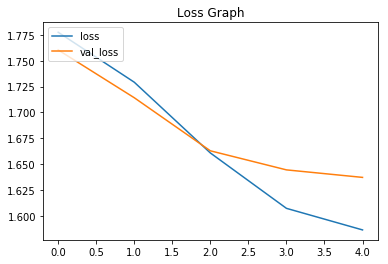

In [6]:
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")


In [7]:
from sklearn.metrics import confusion_matrix
pre = model.predict_classes(x_test)
pd.DataFrame(confusion_matrix(y_test, pre))


,0,1,2,3,4,5
0,0,20,0,0,6,1
1,0,26,0,0,6,1
2,0,7,0,0,1,0
3,0,6,0,0,3,0
4,0,17,0,0,2,0
5,0,18,0,0,9,0
